##  Imports and Setup

#Step 1: Set up the environment by installing packages, fixing conflicts, importing libraries, and downloading data needed for text preprocessing, topic modeling, and visualization.




In [1]:
# STEP 1: Uninstall problematic or partially installed packages
!pip uninstall -y numpy pandas scipy pyLDAvis sklearn
# STEP 2: Install compatible core scientific libraries
!pip install numpy==1.26.4 scipy==1.13.0 pandas==2.2.2

# STEP 3: Install NLP & Topic Modeling libraries
!pip install gensim==4.3.3 scikit-learn==1.0.2
!pip install emoji==2.14.1 funcy textblob tqdm wordcloud future
# STEP 4: Install pyLDAvis without its broken sklearn dependency
!pip install pyLDAvis==3.3.1 --no-deps

#RESTART AFTER RUNNING ABOVE CODE

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 1.5.3
Uninstalling pandas-1.5.3:
  Successfully uninstalled pandas-1.5.3
Found existing installation: scipy 1.13.0
Uninstalling scipy-1.13.0:
  Successfully uninstalled scipy-1.13.0
Found existing installation: pyLDAvis 3.2.0
Uninstalling pyLDAvis-3.2.0:
  Successfully uninstalled pyLDAvis-3.2.0
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86

In [16]:
# STEP 6: Import libraries
!pip install gensim==4.3.3
import pandas as pd
import numpy as np
import nltk
import re
import string
import emoji
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import spacy
from gensim.models import CoherenceModel, LdaMulticore
from gensim.corpora import Dictionary
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.manifold import TSNE

# STEP 7: Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#Step 2: Mount Google Drive to access dataset files directly in Colab.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading and Saving

#Step 3: Load dataset from Parquet, preview it, and save a copy as CSV for easier access and sharing.


In [3]:
# Read parquet
parquet_file_path = '/content/drive/MyDrive/nyt_data.parquet'
df = pd.read_parquet(parquet_file_path, engine='pyarrow')

# Print a few rows to check content
print("Sample Data from Parquet File:")
print(df.head())

# Save as CSV
csv_file_path = '/content/drive/MyDrive/nyt_data.csv'
df.to_csv(csv_file_path, index=False)


Sample Data from Parquet File:
   year                                              title  \
0  1920  At last the Federal Reserve Board has issued r...   
1  1920                            WILL TEST DOOR SERVICE.   
2  1920                    Sanction for Chinese Contracts.   
3  1920                            LEADS FRAZIER BY 4,496.   
4  1920  CHICAGO, April 30.--With 300 suspicious charac...   

                                             excerpt  
0                                                     
1  Service Board to Further Examine I.R.T. Safety...  
2                                                     
3  Langer's Margin Falls in North Dakota--Gronna ...  
4  Federal Agents and Police Round-- up Suspiciou...  


#Step 4: Print detailed information about the dataset, including its shape (rows and columns), column data types, and memory usage to understand its structure and optimize processing.


Dataset Overview:
Number of rows: 17370913
Number of columns: 3

Columns and Data Types:
year        int64
title      object
excerpt    object
dtype: object

Memory usage: 6.0328 GB

Missing Values per Column:
year       0
title      0
excerpt    0
dtype: int64

Statistical Summary (Numeric Columns):
               year
count  1.737091e+07
mean   1.965375e+03
std    2.807526e+01
min    1.920000e+03
25%    1.941000e+03
50%    1.961000e+03
75%    1.990000e+03
max    2.020000e+03


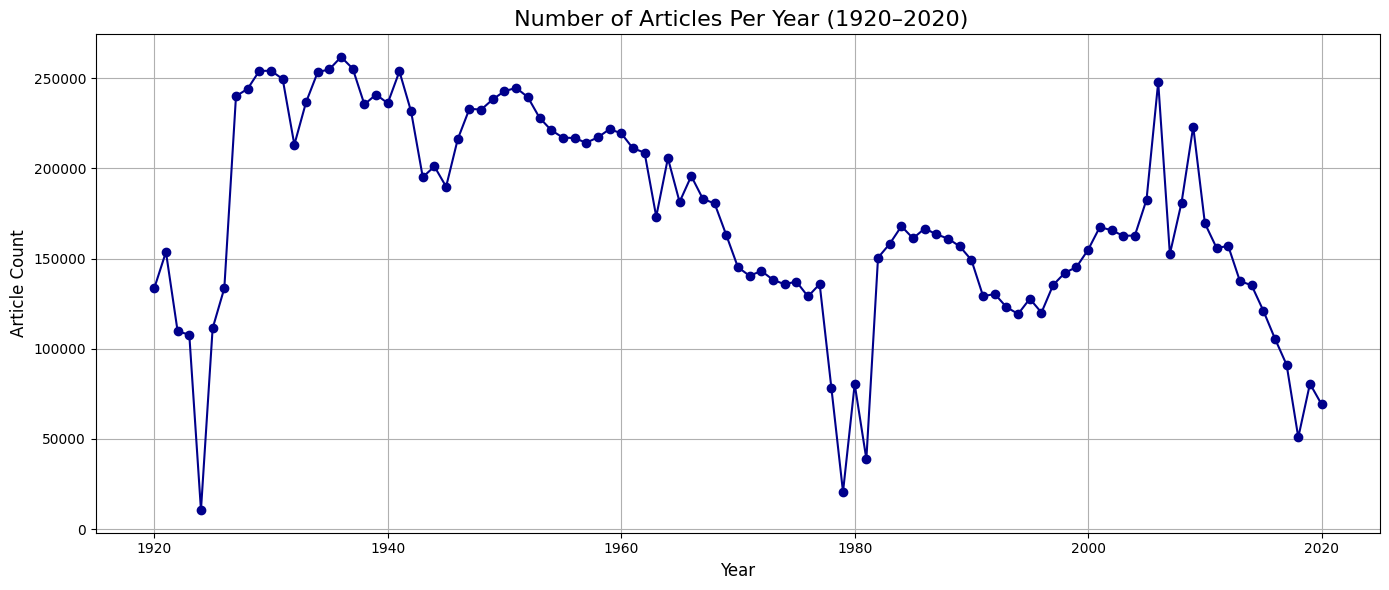

In [4]:
# Print detailed information about the dataset
print("Dataset Overview:")

# 1. Print the number of rows and columns
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# 2. Print the column names and their data types
print("\nColumns and Data Types:")
print(df.dtypes)

# 3. Print memory usage in GB
memory_usage = df.memory_usage(deep=True).sum() / (1024**3)  # Convert bytes to GB
print(f"\nMemory usage: {memory_usage:.4f} GB")

# Count articles per year
article_counts = df['year'].value_counts().sort_index()

# Missing values:
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Top level summary stats
print("\nStatistical Summary (Numeric Columns):")
print(df.describe())

# Plot line chart
plt.figure(figsize=(14, 6))
plt.plot(article_counts.index, article_counts.values, marker='o', color='darkblue')
plt.title(' Number of Articles Per Year (1920–2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Article Count', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## Chunked Reading & Preprocessing

#Step 5: Read the CSV file in chunks to avoid memory issues with large files, then display the first chunk verify correct reading.


In [5]:
# Read the CSV in chunks
chunk_size = 5000  # Adjust based on available RAM
csv_file_path = '/content/drive/MyDrive/nyt_data.csv'

# Preview just the first chunk to check the structure
preview_chunk = next(pd.read_csv(csv_file_path, chunksize=chunk_size))
print("Preview of first chunk:")
print(preview_chunk.head())
print(preview_chunk.columns)


Preview of first chunk:
   year                                              title  \
0  1920  At last the Federal Reserve Board has issued r...   
1  1920                            WILL TEST DOOR SERVICE.   
2  1920                    Sanction for Chinese Contracts.   
3  1920                            LEADS FRAZIER BY 4,496.   
4  1920  CHICAGO, April 30.--With 300 suspicious charac...   

                                             excerpt  
0                                                NaN  
1  Service Board to Further Examine I.R.T. Safety...  
2                                                NaN  
3  Langer's Margin Falls in North Dakota--Gronna ...  
4  Federal Agents and Police Round-- up Suspiciou...  
Index(['year', 'title', 'excerpt'], dtype='object')


# Step 6: This section preprocesses the NYT dataset in chunks by cleaning and stemming the text, then combines and saves the cleaned data for further analysis.



In [6]:

from nltk.stem import PorterStemmer


# Set up fast tools
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def fast_preprocess(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)

# File path and chunking
csv_file_path = '/content/drive/MyDrive/nyt_data.csv'
chunk_size = 250000  # Try a higher chunk size if RAM allows

processed_chunks = []
chunks = pd.read_csv(csv_file_path, chunksize=chunk_size)

for chunk in tqdm(chunks, desc="Processing Chunks"):
    chunk = chunk.dropna(subset=["excerpt"]).reset_index(drop=True)
    chunk = chunk[['excerpt', 'year']]  # Explicitly keep year
    chunk['processed_text'] = chunk['excerpt'].apply(fast_preprocess)
    processed_chunks.append(chunk)

# Combine and save
processed_df = pd.concat(processed_chunks, ignore_index=True)
processed_df.to_csv("/content/drive/MyDrive/processed_data.csv", index=False)


Processing Chunks: 70it [29:43, 25.47s/it]


##  Topic Analysis

#Step 7: This section trains an LDA topic model on a sample of the processed data, optimizes for better coherence, and evaluates model quality using the 'c_v' metric.

In [7]:
import multiprocessing

# 1. Limit dataset to first 100,000 rows (start smaller to check results)
sample_df = processed_df.iloc[:100000].copy()

# 2. Tokenize text
texts = [doc.split() for doc in sample_df['processed_text']]  # List of tokenized documents

# 3. Create dictionary and filter extreme terms
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=50, no_above=0.5, keep_n=20000)

# 4. Create Bag-of-Words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# 5. Train LDA model with better configuration
lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=15,  # Adjust the number of topics
    passes=20,      # Increase passes for better convergence
    iterations=1000,  # Increase iterations for each pass
    workers=max(1, multiprocessing.cpu_count() - 1),
    chunksize=20000,  # Increase chunksize to speed up training
    random_state=42
)

# 6. Coherence Score using 'c_v' metric for better results (pass texts)
coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, texts=texts, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score:.4f}")


Coherence Score: 0.5434


# Step 8: Assigned the dominant topic to each document based on the highest probability from the LDA model and printed the excerpt along with its corresponding dominant topic.


In [21]:
# Get the topic distributions for each document in the corpus
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0.0)

# Assign the dominant topic to each document
sample_df['dominant_topic'] = [max(dist, key=lambda x: x[1])[0] for dist in topic_distributions]

# Print the dominant topic for the first few documents (optional)
print(sample_df[['excerpt', 'dominant_topic']].head())


                                             excerpt  dominant_topic
0  Service Board to Further Examine I.R.T. Safety...              13
1  Langer's Margin Falls in North Dakota--Gronna ...               6
2  Federal Agents and Police Round-- up Suspiciou...              10
3  Fall Upon Column in Ravine Near Urfa and Murde...               5
4  Frank A. Munsey, at Senate Hearing, Says Wood ...               0


#Step 9:  Group the data by 'year' and 'dominant_topic' to count topic occurrences, normalize the topic distribution by year, and then plot the trends of each topic over time, showing the proportional changes in topics across years.




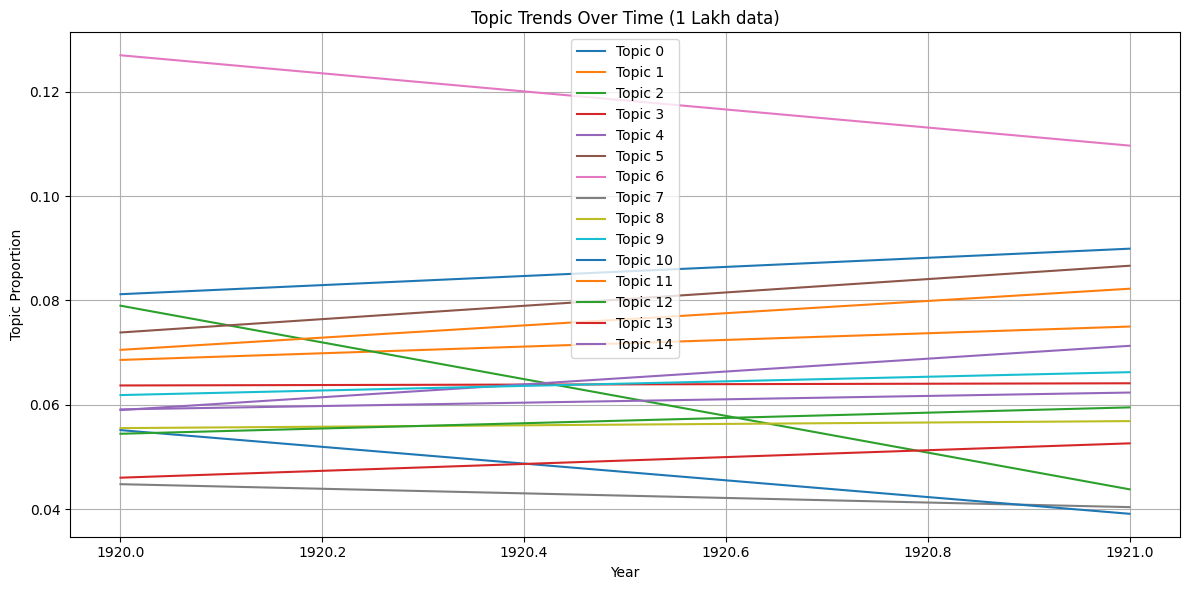

In [9]:
# 8. Group by year and dominant topic
trends = sample_df.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

# 9. Normalize topic distribution by year
trends_norm = trends.div(trends.sum(axis=1), axis=0)

# 10. Plot topic trends over time
plt.figure(figsize=(12, 6))
for topic in trends_norm.columns:
    plt.plot(trends_norm.index, trends_norm[topic], label=f'Topic {topic}')
plt.title('Topic Trends Over Time (1 Lakh data)')
plt.xlabel('Year')
plt.ylabel('Topic Proportion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Display the top words for each topic from the LDA model, showing the most frequent terms that define each topic.


In [10]:
# 11. Display top words per topic
def display_gensim_topics(model, num_words=10):
    for idx, topic in model.show_topics(num_topics=-1, num_words=num_words, formatted=False):
        words = " | ".join([word for word, _ in topic])
        print(f"Topic {idx + 1}: {words}")

display_gensim_topics(lda_model, num_words=10)

Topic 1: new | committe | say | board | plan | ask | compani | state | propos | bill
Topic 2: court | say | charg | case | judg | attorney | action | law | deni | juri
Topic 3: presid | republican | state | senat | democrat | say | hard | vote | leader | parti
Topic 4: say | leagu | senat | would | declar | treati | paper | resolut | call | america
Topic 5: mr | miss | wife | stock | exchang | american | daughter | year | new | woman
Topic 6: polic | kill | two | man | arrest | one | three | fire | found | held
Topic 7: win | defeat | score | game | race | match | victori | tourney | first | second
Topic 8: street | build | hous | properti | buy | avenu | deal | west | purchas | ship
Topic 9: men | meet | next | game | play | footbal | season | week | good | practic
Topic 10: say | war | tell | washington | french | franc | declar | georg | women | london
Topic 11: red | report | armi | govern | said | forc | strike | soviet | german | order
Topic 12: price | market | report | govern |

# Step 11: Generate and display word clouds for each topic, visualizing the top 30 words with the highest weights for each topic.


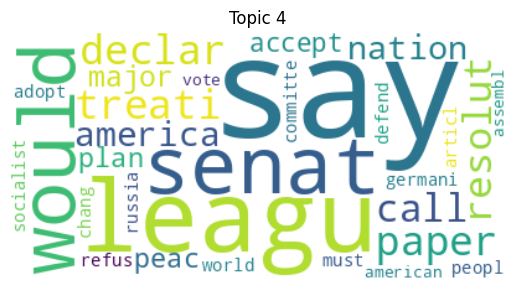

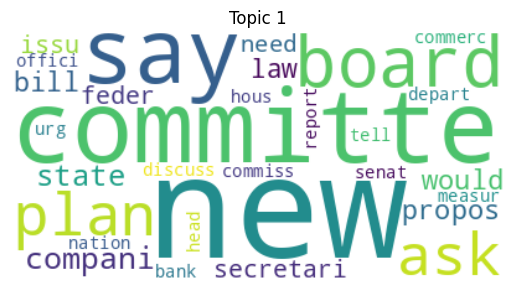

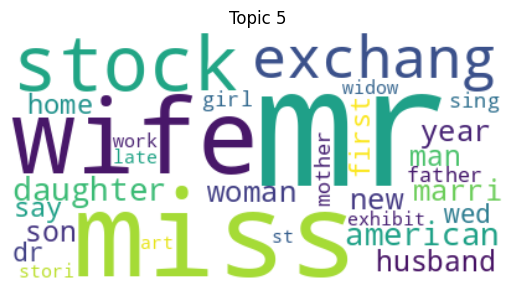

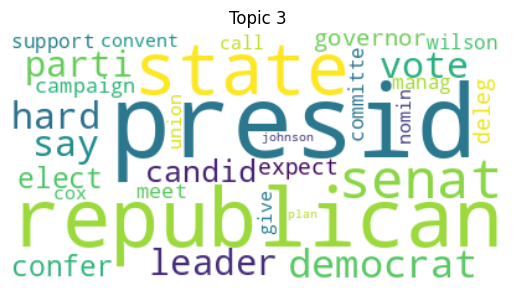

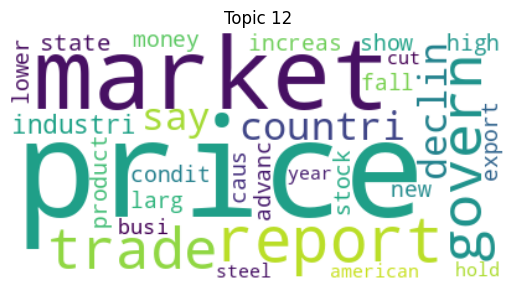

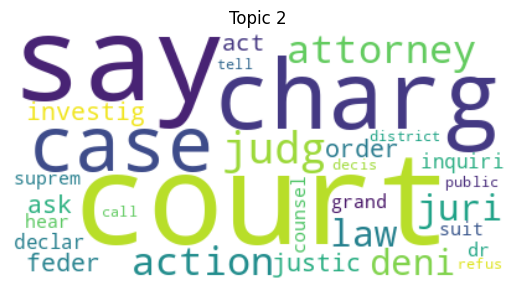

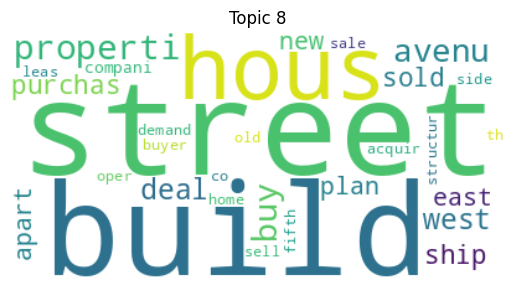

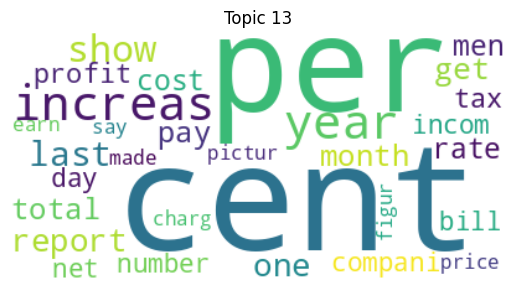

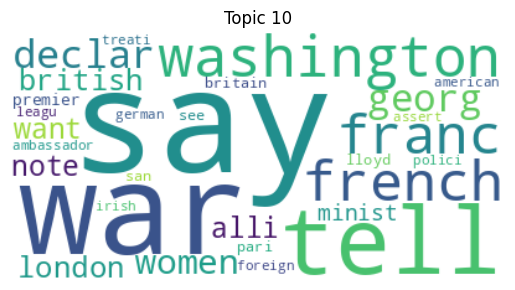

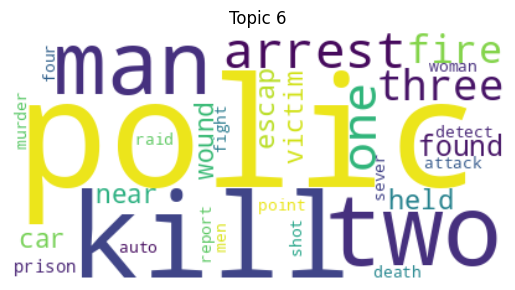

In [11]:
# 12. WordClouds per topic
for idx, topic in lda_model.show_topics(num_topics=10, num_words=30, formatted=False):
    freq_dict = {word: weight for word, weight in topic}
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(freq_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {idx + 1}')
    plt.show()

# Step 12: Plot horizontal bar charts showing the top words and their respective weights for each topic in the LDA model.


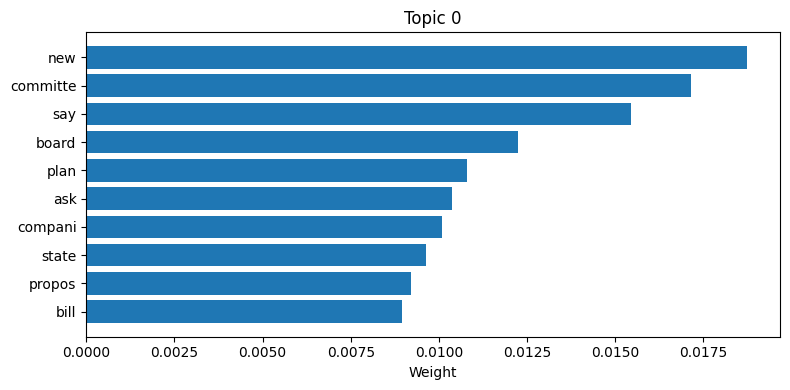

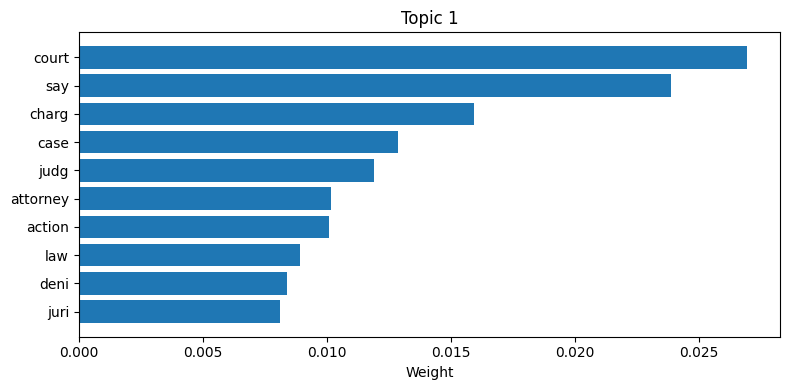

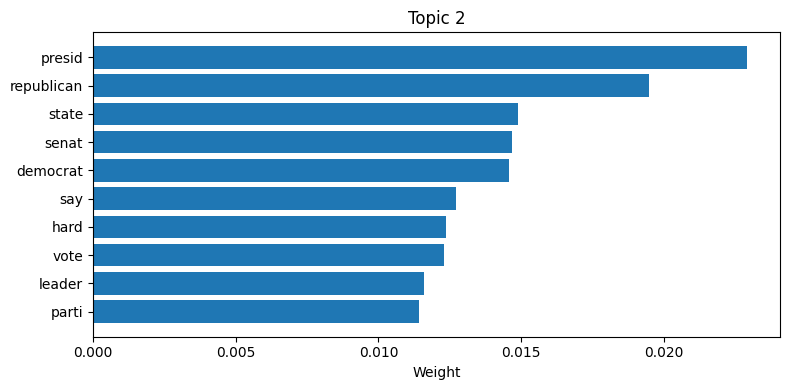

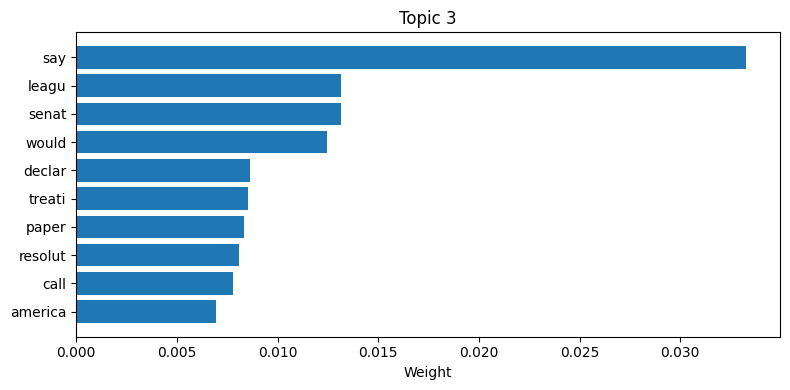

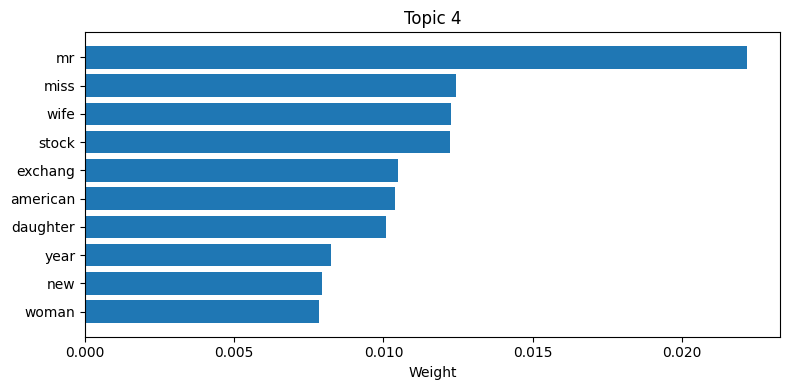

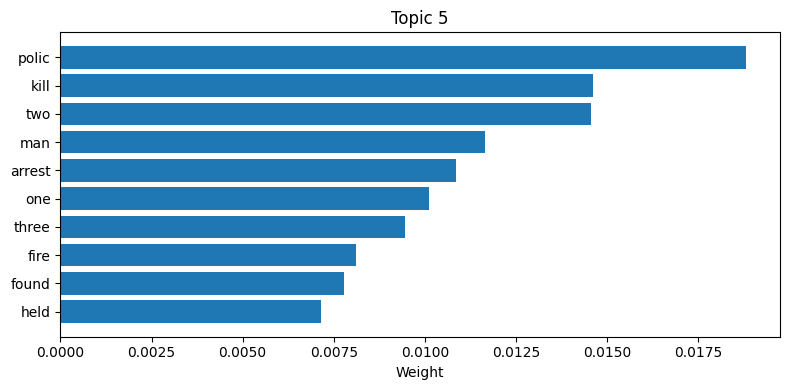

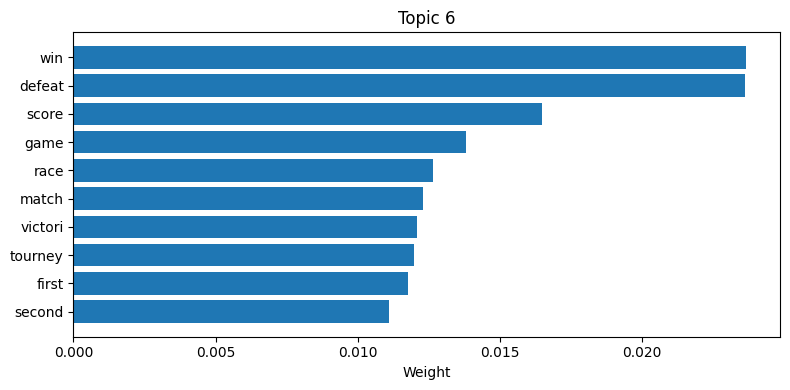

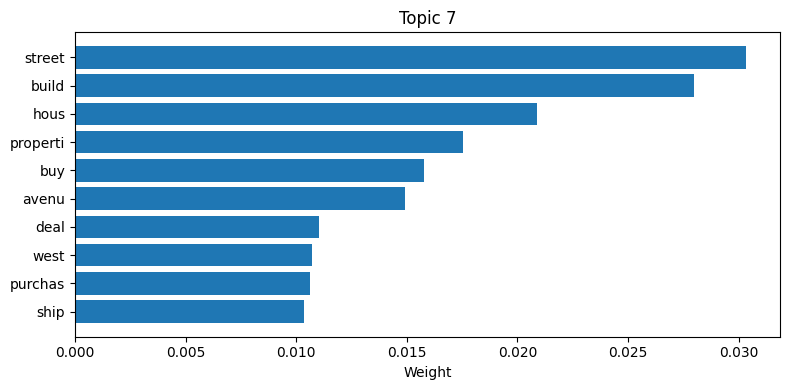

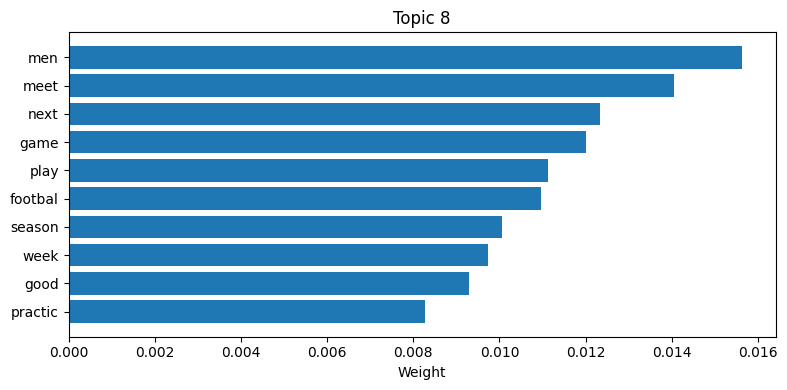

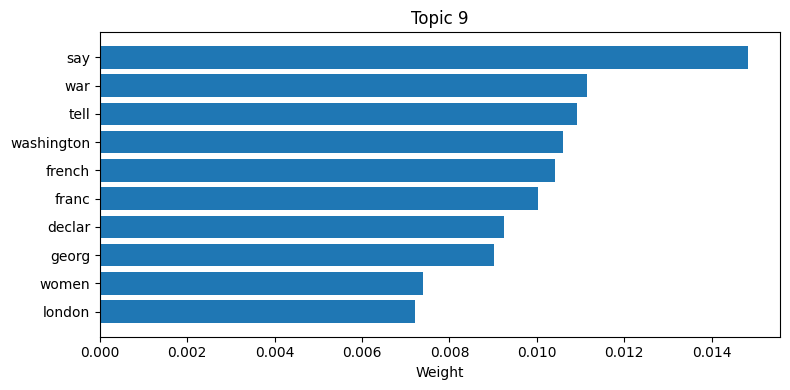

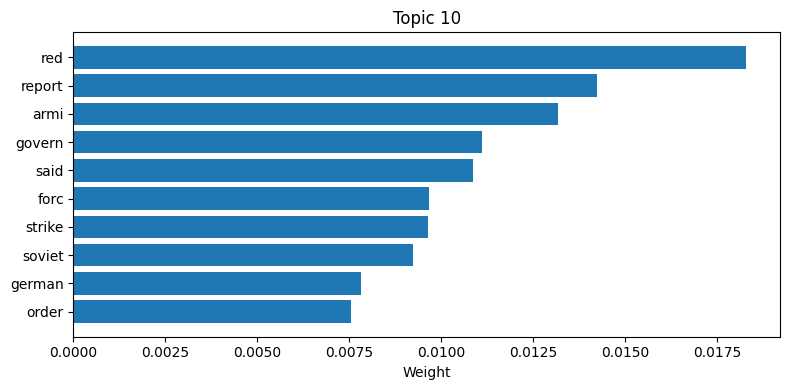

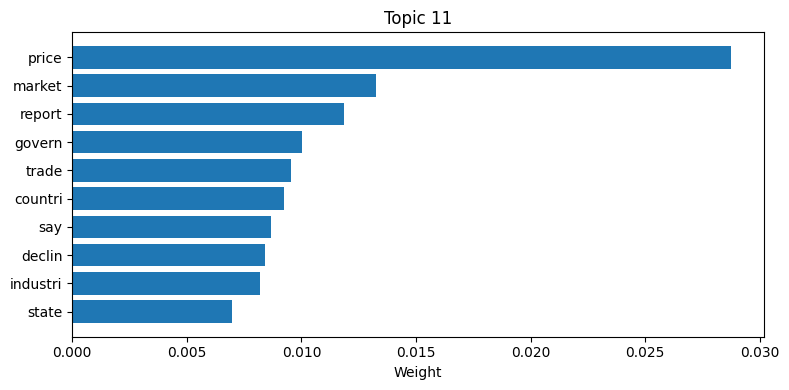

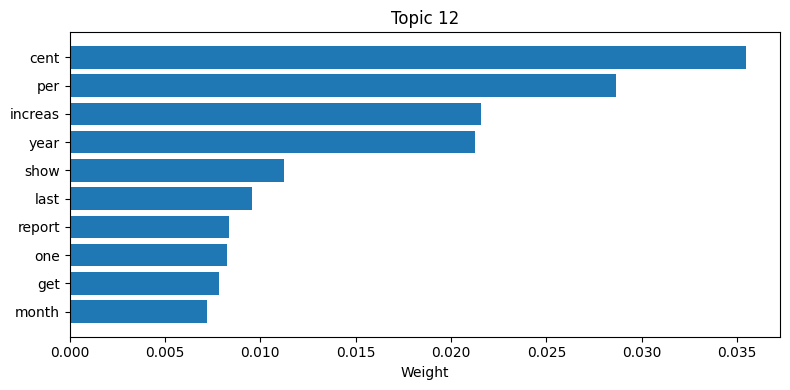

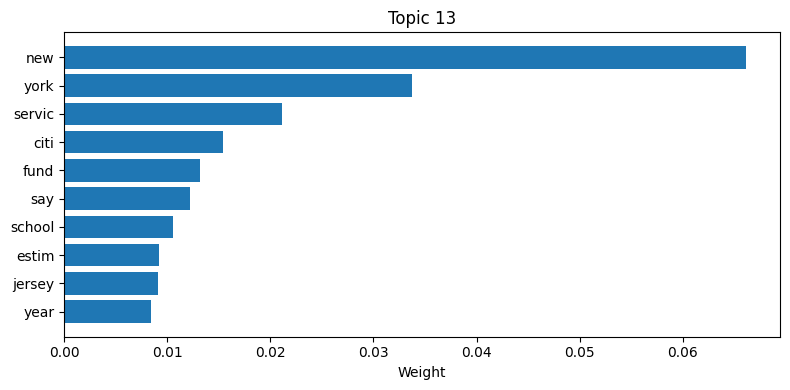

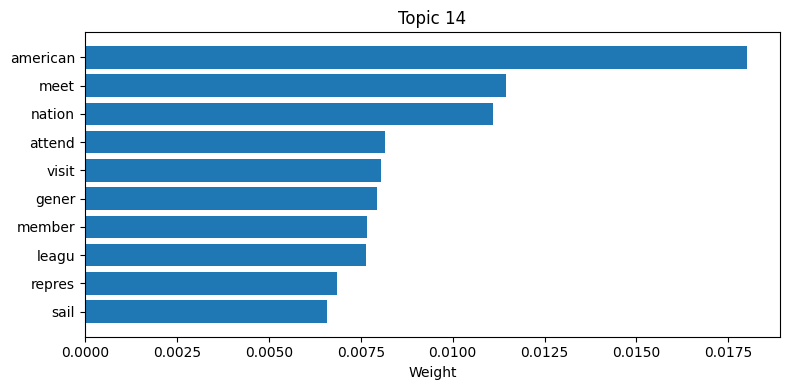

In [14]:
def plot_top_words_per_topic(lda_model, num_words=10):
    for topic_id in range(lda_model.num_topics):
        top_words = lda_model.show_topic(topic_id, topn=num_words)
        words = [word for word, _ in top_words]
        weights = [weight for _, weight in top_words]

        plt.figure(figsize=(8, 4))
        plt.barh(words[::-1], weights[::-1])
        plt.title(f'Topic {topic_id}')
        plt.xlabel('Weight')
        plt.tight_layout()
        plt.show()

plot_top_words_per_topic(lda_model)

# Step 13: Convert the document-topic distributions to a matrix and apply t-SNE for dimensionality reduction, then visualize the topics in 2D, coloring by the dominant topic for each document.


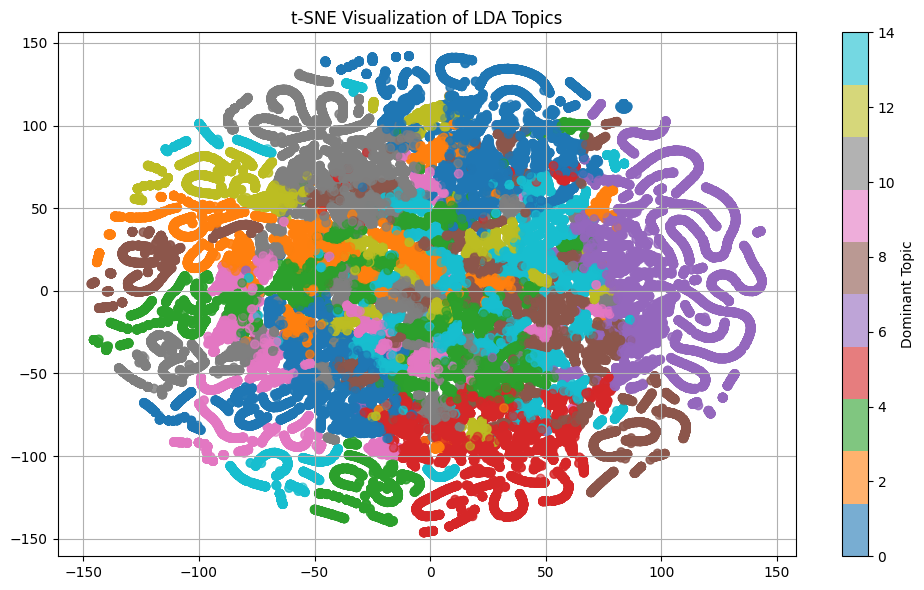

In [18]:
# Convert topic distributions into dense format
doc_topics = [lda_model.get_document_topics(doc, minimum_probability=0.0) for doc in corpus]
doc_topic_matrix = np.array([[prob for _, prob in doc] for doc in doc_topics])

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(doc_topic_matrix)

# Plot with topic color
dominant_topics = np.argmax(doc_topic_matrix, axis=1)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dominant_topics, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Dominant Topic')
plt.title('t-SNE Visualization of LDA Topics')
plt.grid(True)
plt.tight_layout()
plt.show()
